In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from copy import deepcopy
from scipy.optimize import curve_fit
import plotly.express as px


### Read curated dataset

In [71]:
path = r"C:/Users/khoah/CovertLabProjects/inner_membrane_curated.csv"
df = pd.read_csv(path)

### Plot frequency of available structure

In [72]:
is_complex_counts = df.is_complex.value_counts()
prot_membrane_type = df.protein_integration_type.value_counts()

In [73]:
monomer_af_counts = len(df[(df.is_complex==0) & (df.selected_single_structure.apply(lambda x: isinstance(x, str) and "AF" in x))].id.unique())
monomer_pdb_counts = len(df[(df.is_complex==0) & (df.selected_single_structure.apply(lambda x: isinstance(x, str) and "AF" not in x))].id.unique())
complex_pdb_counts = len(df[(df.is_complex!=0) & (~df.selected_single_structure.isna())].complex.unique())
complex_undertemined_counts = len(df[(df.is_complex!=0) & (~df.selected_single_structure.isna())].complex.unique())

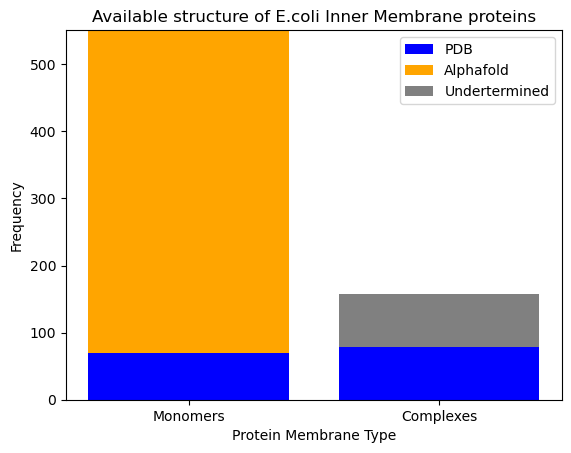

In [74]:
categories = ['Monomers', 'Complexes']
data = {
    'PDB': [monomer_pdb_counts, complex_pdb_counts],
    'Alphafold': [monomer_af_counts, 0],
    'Undertermined': [0, complex_undertemined_counts],
}

# Convert the data into a stacked format
bottom = [0] * len(categories)
colors = ['blue', 'orange', 'gray']

# Create a stacked barplot
for group, color in zip(data.keys(), colors):
    values = data[group]
    plt.bar(categories, values, label=group, bottom=bottom, color=color)
    bottom = np.add(bottom, values)

# Add labels and a legend
plt.xlabel('Protein Membrane Type')
plt.ylabel('Frequency')
plt.title('Available structure of E.coli Inner Membrane proteins')
plt.legend()

# Show the plot
plt.show()

### Change unit to um

In [75]:
df.area_full = round(df.area_full*0.01, 3)
df.area_inward = round(df.area_inward*0.01, 3)
df.area_outward = round(df.area_outward*0.01, 3)
df.area_trans = round(df.area_trans*0.01, 3)

### Subset to monomers and complex with known structures only

In [77]:
df_known_structures = df.drop_duplicates("selected_single_structure")
df_known_structures = df_known_structures.dropna(subset = ["selected_single_structure"])

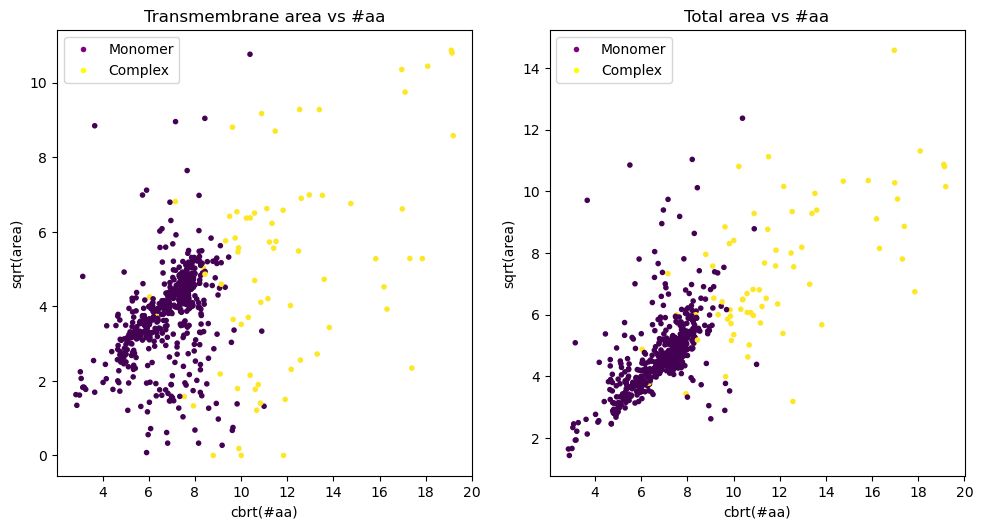

In [78]:
plt.figure(figsize=(10,10), tight_layout = True)
plt.subplot(221)
plt.scatter(np.cbrt(df_known_structures.aa_nums), np.sqrt(df_known_structures.area_trans),\
            marker = ".", c=df_known_structures.is_complex)
plt.xlabel("cbrt(#aa)")
plt.ylabel("sqrt(area)")
plt.title("Transmembrane area vs #aa")
legend_labels = ['Monomer', 'Complex']  # Modify these labels as needed
handles = [plt.Line2D([0], [0], marker='.', color='w', markerfacecolor=color, markersize=10) for color in ['purple', 'yellow']]
plt.legend(handles, legend_labels)
plt.subplot(222)
plt.scatter(np.cbrt(df_known_structures.aa_nums), np.sqrt(df_known_structures.area_full),\
            marker = ".", c=df_known_structures.is_complex)
plt.xlabel("cbrt(#aa)")
plt.ylabel("sqrt(area)")
plt.title("Total area vs #aa")
legend_labels = ['Monomer', 'Complex']  # Modify these labels as needed
handles = [plt.Line2D([0], [0], marker='.', color='w', markerfacecolor=color, markersize=10) for color in ['purple', 'yellow']]
plt.legend(handles, legend_labels)
plt.show()

### Peripheral vs Transmembrane Protein

In [81]:
prot_membrane_type = df.protein_integration_type.value_counts()
prot_type_dict = {"trans": "transmembrane", "outward": "peripheral", "inward": "peripheral"}
prot_membrane_type = df_known_structures.protein_integration_type.map(prot_type_dict).value_counts()
df_known_structures["mem_type"] = df_known_structures.protein_integration_type.map(prot_type_dict)

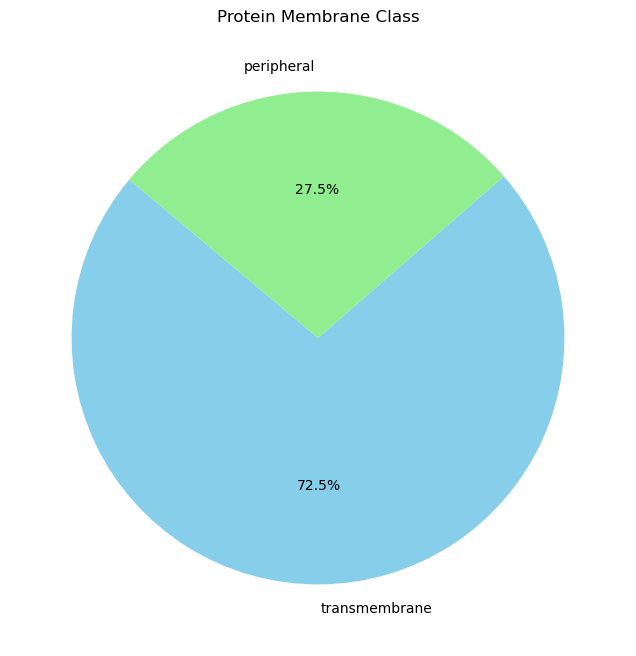

In [82]:
labels = prot_membrane_type.index
sizes = prot_membrane_type.values
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
plt.title('Protein Membrane Class')
plt.show()

### subset for transmebrane protein

In [83]:
df_known_structures_trans = df_known_structures[(df_known_structures.mem_type == "transmembrane")]
mean_area = df_known_structures_trans.groupby("is_complex").area_trans.mean()

Text(0.5, 1.0, 'Histogram showing Membrane Area Occupany \nof unique Monomers and Complexes')

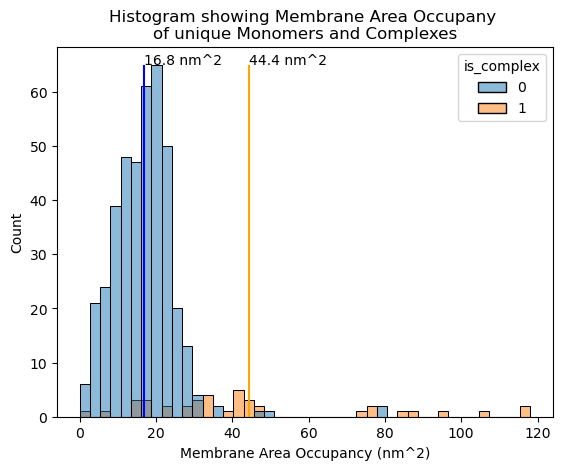

In [84]:
sns.histplot(data=df_known_structures_trans, hue = "is_complex", x = "area_trans")
plt.xlabel("Membrane Area Occupancy (nm^2)")
plt.vlines(x=mean_area[0.0], ymin=0, ymax=65, color = "blue")
plt.vlines(x=mean_area[1.0], ymin=0, ymax=65, color = "orange")
plt.text(s=f"{round(mean_area[0.0],1)} nm^2", x = mean_area[0.0], y = 65)
plt.text(s=f"{round(mean_area[1.0],1)} nm^2", x = mean_area[1.0], y = 65)
plt.title("Histogram showing Membrane Area Occupany \nof unique Monomers and Complexes")

### Load Protein Counts from Simulation

In [85]:
df_counts = pd.read_csv(r"C:/Users/khoah/Downloads/monomer_and_complex_counts_header.csv")

### plot protein counts in different compartments 

In [89]:
non_inner_membrane_col = [x for x in list(df_counts.columns) if x[-3:] != "[i]"]
inner_membrane_col = [x for x in list(df_counts.columns) if x[-3:] == "[i]"]
cytosol_col = [x for x in list(df_counts.columns) if x[-3:] == "[c]"]

df_counts_inner = df_counts.drop(columns=non_inner_membrane_col)
# remove compartment from protein name
df_counts_inner.columns = [i[:-3] for i in df_counts_inner.columns]
df_counts_non_inner = df_counts.drop(columns=inner_membrane_col)
df_counts_cytosol = df_counts[cytosol_col]


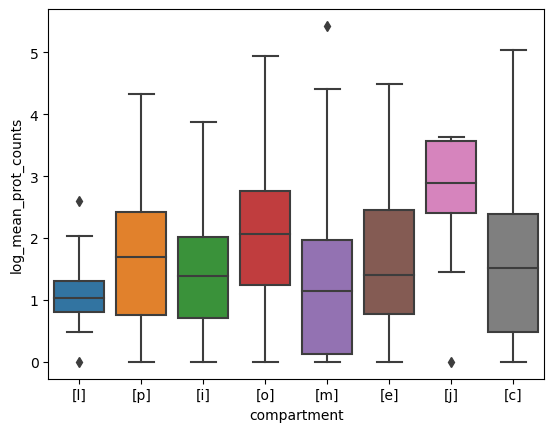

In [90]:
all_df_compartments = []
compartments = list(set([x[-3:] for x in list(df_counts.columns)]))
cleaned_compartments = [comp for comp in compartments if "." not in comp]
for compartment in cleaned_compartments:
    prot_col = [x for x in list(df_counts.columns) if x[-3:] != compartment]
    df_compartment = df_counts.drop(columns=prot_col)
    all_df_compartments.append(df_compartment)
mean_vals = np.log10(pd.concat(all_df_compartments ,axis = 1).values.mean(axis=0) + 1)
compartment_cols = []
for i, comp in enumerate(cleaned_compartments):
    compartment_cols.extend([cleaned_compartments[i] for k in range(len(all_df_compartments[i].columns))])
df_compartments = pd.DataFrame({"log_mean_prot_counts": mean_vals, "compartment": compartment_cols})
sns.boxplot(data = df_compartments, y = "log_mean_prot_counts", x = "compartment")
plt.show()

In [92]:
df_known_structures_trans_monomers = df_known_structures_trans[df_known_structures_trans.is_complex == 0.]
df_known_structures_trans_complexes = df_known_structures_trans[df_known_structures_trans.is_complex == 1.]

In [93]:
#filter for column of known structure only
valid_col = [col for col in df_counts_inner.columns if col in df_known_structures_trans_monomers.id.to_list() \
                or col in df_known_structures_trans_complexes.complex.to_list()]
df_counts_inner_filtered = df_counts_inner[valid_col]

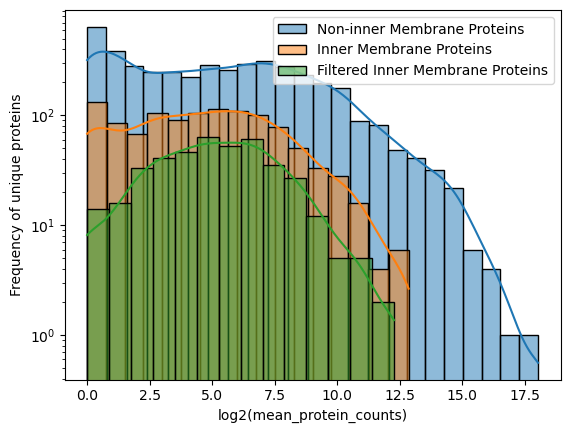

In [94]:
# sns.histplot(np.log10(df_counts.values.mean(axis=0).ravel()+1), kde=True, label = "All Proteins")
sns.histplot(np.log2(df_counts_non_inner.values.mean(axis=0).ravel()+1), kde=True, label = "Non-inner Membrane Proteins")
sns.histplot(np.log2(df_counts_inner.values.mean(axis=0).ravel()+1), kde=True, label = "Inner Membrane Proteins")
sns.histplot(np.log2(df_counts_inner_filtered.values.mean(axis=0).ravel()+1), kde=True, label = "Filtered Inner Membrane Proteins")

plt.xlabel("log2(mean_protein_counts)")
plt.ylabel("Frequency of unique proteins")
plt.yscale('log')

plt.legend()
plt.show()

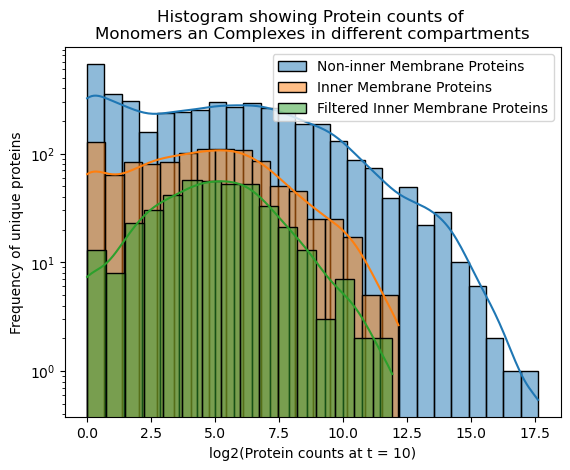

In [45]:
t = 10
sns.histplot(np.log2(df_counts_non_inner.values[t]+1), kde=True, label = "Non-inner Membrane Proteins")
sns.histplot(np.log2(df_counts_inner.values[t]+1), kde=True, label = "Inner Membrane Proteins")
sns.histplot(np.log2(df_counts_inner_filtered.values[t]+1), kde=True, label = "Filtered Inner Membrane Proteins")

plt.xlabel("log2(Protein counts at t = 10)")
plt.ylabel("Frequency of unique proteins")
plt.yscale('log')
plt.title("Histogram showing Protein counts of \nMonomers an Complexes in different compartments")
plt.legend()
plt.show()

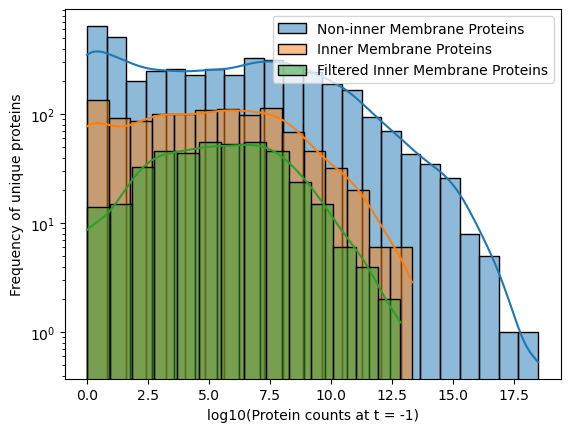

In [48]:
t = -1
sns.histplot(np.log2(df_counts_non_inner.values[t]+1), kde=True, label = "Non-inner Membrane Proteins")
sns.histplot(np.log2(df_counts_inner.values[t]+1), kde=True, label = "Inner Membrane Proteins")
sns.histplot(np.log2(df_counts_inner_filtered.values[t]+1), kde=True, label = "Filtered Inner Membrane Proteins")

plt.xlabel("log10(Protein counts at t = -1)")
plt.ylabel("Frequency of unique proteins")
plt.yscale('log')

plt.legend()
plt.show()

### Assumming volume as a function of protein counts

[1.14216595e-01 2.76370286e+02 2.14962122e+06]


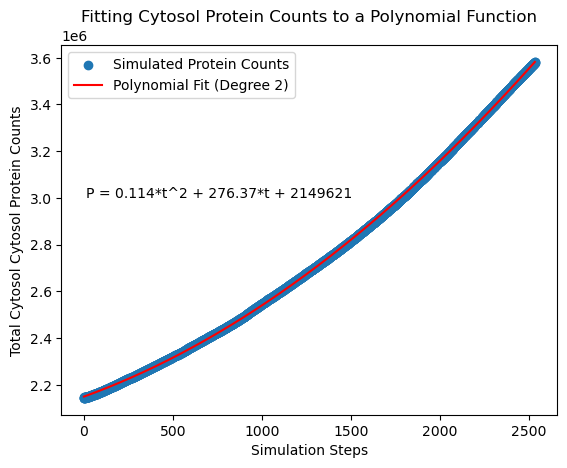

In [95]:
# Sample time series data
x = np.arange(0,len(df_counts_cytosol.sum(axis = 1)))
y = df_counts_cytosol.sum(axis = 1)

# Degree of the polynomial fit
degree = 2

# Perform the polynomial fit
coefficients = np.polyfit(x, y, degree)

# Generate the fitted curve
x_fit = np.linspace(min(x), max(x), 2533)
y_fit = np.polyval(coefficients, x_fit)

print(coefficients)
# Plot the original data and the fitted curve
plt.scatter(x, y, label='Simulated Protein Counts')
plt.plot(x_fit, y_fit, label=f'Polynomial Fit (Degree {degree})', color='red')
plt.xlabel('Simulation Steps')
plt.ylabel('Total Cytosol Cytosol Protein Counts')
plt.text(s = "P = {0}*t^2 + {1}*t + {2}".format(round(coefficients[0],3), \
                                        round(coefficients[1],3), round(coefficients[2])), x = 10, y = 3*10**6)

plt.title("Fitting Cytosol Protein Counts to a Polynomial Function")
plt.legend()
plt.show()


In [96]:
r = 0.33
t = np.arange(2534)
Pt = np.round(0.114*t**2 + 276**t + 2.149*(10**6))
Vt =  (0.6) / (2.149e6) * y_fit
ht = (Vt - (4/3) * np.pi * r**3) /(np.pi * r**2)
St = 2*np.pi*r*(ht) +  4*np.pi*r**2

Text(0, 0.5, 'Volume (um^3)')

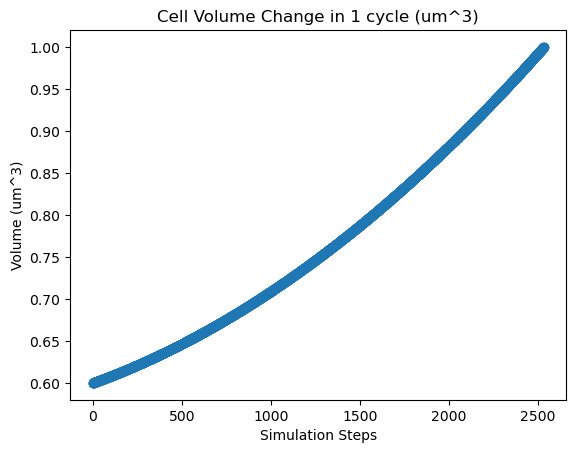

In [97]:
plt.scatter(x_fit, Vt, label = "Volume")
plt.title("Cell Volume Change in 1 cycle (um^3)")
plt.xlabel("Simulation Steps")
plt.ylabel("Volume (um^3)")

Text(0, 0.5, 'Area (um^2)')

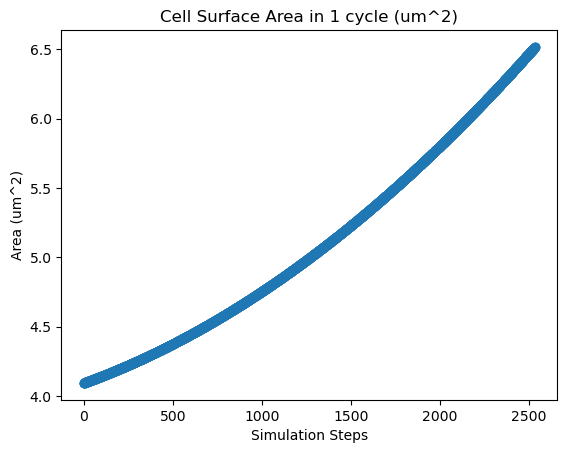

In [54]:
plt.scatter(x_fit, St, label = "Volume")
plt.title("Cell Surface Area in 1 cycle (um^2)")
plt.xlabel("Simulation Steps")
plt.ylabel("Area (um^2)")

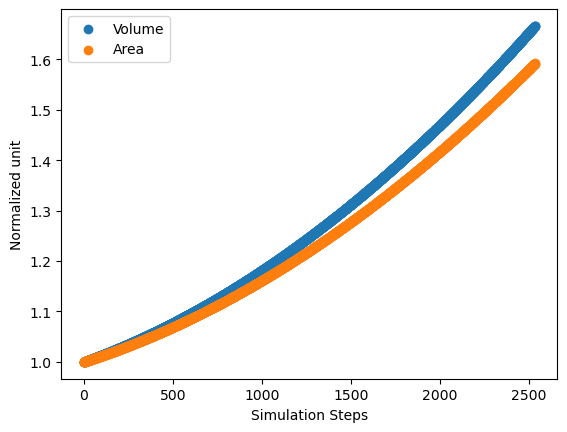

In [55]:
# plt.scatter(x_fit, ht)
plt.scatter(x_fit, Vt/Vt[0], label = "Volume")
plt.scatter(x_fit, St/St[0], label = "Area")
plt.xlabel("Simulation Steps")
plt.ylabel("Normalized unit")
plt.legend()

Text(0, 0.5, 'S/V')

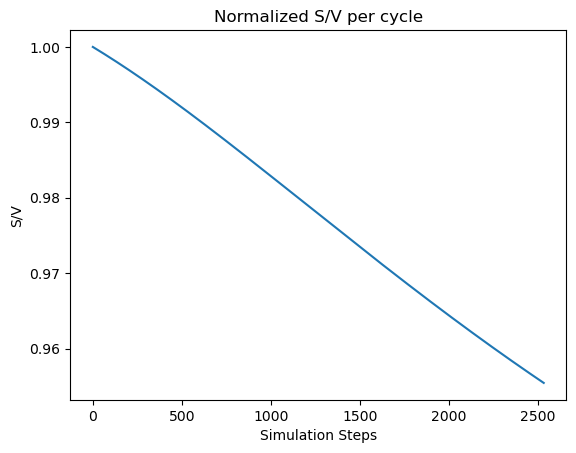

In [56]:
plt.plot((St/St[0])/(Vt/Vt[0]))
plt.title("Normalized S/V per cycle")
plt.xlabel("Simulation Steps")
plt.ylabel("S/V")

In [98]:
mean = df_counts_inner_filtered.mean()

In [100]:
fold_change = (df_counts_inner_filtered.loc[2532:2532].values + 1) / (df_counts_inner_filtered.loc[:0].values +  1)

In [101]:
var_coef = df_counts_inner_filtered.std() / (df_counts_inner_filtered.mean() + 1) * 100
var_coef = df_counts_inner_filtered.std() / (df_counts_inner_filtered.mean() + 1) * 100


In [102]:
complex_dict = {}
complex_common_name_dict = {}
monomer_common_name_dict = {}

for c in df_known_structures_trans_complexes.complex.to_list():
    complex_dict[c] = "complex"
    complex_common_name_dict[c] =\
            df_known_structures_trans_complexes[df_known_structures_trans_complexes.complex == c].complex_common_name.values[0]
for m in df_known_structures_trans_monomers.id.to_list():
    monomer_common_name_dict[m] =\
            df_known_structures_trans_monomers[df_known_structures_trans_monomers.id == m].common_name.values[0]

In [113]:
protein_area_dict = {}
monomer_area_dict = df_known_structures_trans_monomers.set_index("id")["area_full"].to_dict()
complex_area_dict = df_known_structures_trans_complexes.set_index("complex")["area_full"].to_dict()
protein_area_dict.update(complex_area_dict)
protein_area_dict.update(monomer_area_dict)

In [124]:
df_scatter_plot = pd.DataFrame()
df_scatter_plot["protein"] = df_counts_inner_filtered.columns.to_list()
df_scatter_plot["fold_change"] = fold_change[0]
df_scatter_plot["var_coef"] = var_coef.values
df_scatter_plot["log2_mean_count"] = np.log2(mean.values +1)
df_scatter_plot["mean"] = mean.values

df_scatter_plot["type"] = df_scatter_plot["protein"].map(complex_dict)
df_scatter_plot["type"] = df_scatter_plot["type"].fillna("monomer")
df_scatter_plot["complex_common_name"] = df_scatter_plot["protein"].map(complex_common_name_dict)
df_scatter_plot["monomer_common_name"] = df_scatter_plot["protein"].map(monomer_common_name_dict)
df_scatter_plot["common_name"] = df_scatter_plot["complex_common_name"].fillna("") \
                                + df_scatter_plot["monomer_common_name"].fillna("").astype(str)

df_scatter_plot["area_trans"] = df_scatter_plot.protein.map(protein_area_dict)
df_scatter_plot["area_full"] = df_scatter_plot.protein.map(protein_area_dict)

df_scatter_plot["t10"] = df_counts_inner_filtered.loc[10].values
df_scatter_plot["t2500"] = df_counts_inner_filtered.loc[2500].values
df_scatter_plot["t10_percentage"] = round(df_scatter_plot["t10"] * 100 / df_scatter_plot["t10"].sum(), 3)
df_scatter_plot["t2500_percentage"] = round(df_scatter_plot["t2500"] * 100 / df_scatter_plot["t2500"].sum(), 3)

df_scatter_plot["t10_area_full"] = df_scatter_plot.t10 * df_scatter_plot.area_full
df_scatter_plot["t10_area_trans"] = df_scatter_plot.t10 * df_scatter_plot.area_trans
df_scatter_plot["t2500_area_full"] = df_scatter_plot.t2500 * df_scatter_plot.area_full
df_scatter_plot["t2500_area_trans"] = df_scatter_plot.t2500 * df_scatter_plot.area_trans

df_scatter_plot["mean_percentage"] = round(df_scatter_plot["mean"] * 100 / df_scatter_plot["mean"].sum(), 3)
df_scatter_plot["t10_count_percent"] = round(df_scatter_plot.t10 * 100 / df_scatter_plot.t10.sum(), 3)
df_scatter_plot["t10_area_trans_percent"] = round(df_scatter_plot.t10_area_trans * 100 / df_scatter_plot.t10_area_trans.sum(), 3)
df_scatter_plot["t2500_count_percent"] = round(df_scatter_plot.t2500 * 100 / df_scatter_plot.t2500.sum(), 3)
df_scatter_plot["t2500_area_trans_percent"] = round(df_scatter_plot.t2500_area_trans * 100 / df_scatter_plot.t2500_area_trans.sum(), 3)

In [125]:
fig = px.scatter(df_scatter_plot, x="area_trans", y="t10", color="type",\
                  hover_data=['protein', "common_name"], \
                 title="Ecoli IMP Protein Membrane Occupany vs Count at t10")
fig.update_layout(yaxis_title='Protein Count')
fig.update_layout(xaxis_title='Membrane Occupancy (nm^2)')
fig.show()

In [126]:
fig = px.scatter(df_scatter_plot, x="log2_mean_count", y="fold_change", color="type",\
                  hover_data=['protein', "common_name"], \
                 title="Ecoli Inner Membrane Protein Log2 Mean Count vs Fold Change in 1 Cycle")
fig.show()

In [127]:
fig = px.scatter(df_scatter_plot, x="log2_mean_count", y="var_coef", color="type",\
                  hover_data=['protein', "common_name"],\
                    title="Ecoli Inner Membrane Protein Log2 Mean Count vs Coefficient of Variance")
fig.show()

In [128]:
fig = px.treemap(df_scatter_plot,\
                 path=[px.Constant("Ecoli Inner Membrane Proteome"), 'protein'], \
                 values="t10", custom_data = ["common_name", "t10_count_percent"], color = "type", \
                 title="Ecoli IMP counts at t=10")
# fig.data[0].textinfo = 'name'
# fig.update_traces(textinfo='label+text', textfont_size=12)
fig.update_traces(hovertemplate='''Count: %{value} <br>Percent: %{customdata[1]}<br>Name: %{customdata[0]}''')

fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.show()

In [147]:
fig = px.treemap(df_scatter_plot,\
                 path=[px.Constant("Ecoli Inner Membrane Proteome"), 'protein'], \
                 values="t10_area_trans", custom_data = ["common_name", "t10_area_trans_percent"], color = "type", \
                 title="Ecoli IMP Membrane Occupancy at t=10")
# fig.data[0].textinfo = 'name'
# fig.update_traces(textinfo='label+text', textfont_size=12)
fig.update_traces(hovertemplate='''Area: %{value} <br>Percent: %{customdata[1]}<br>Name: %{customdata[0]}''')

fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.show()

### top 10 occupancy

In [148]:
top10_t10 = df_scatter_plot.sort_values("t10_area_trans", ascending = False)[:10].protein.to_list()

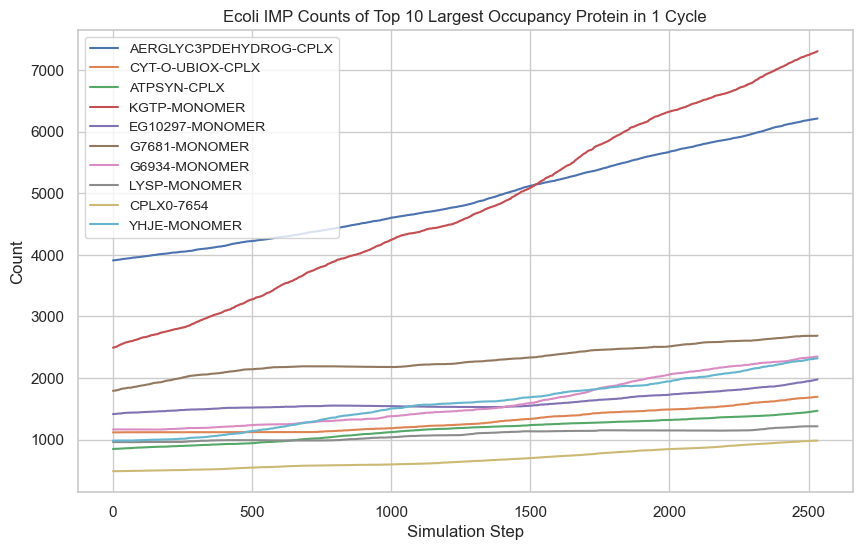

In [149]:
#e it suitable for Seaborn
df_melted = pd.melt(df_counts_inner_filtered[top10_t10].reset_index(), id_vars='index', var_name='Column', value_name='Value')
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.lineplot(x='index', y='Value', hue='Column', data=df_melted)
plt.title('Ecoli IMP Counts of Top 10 Largest Occupancy Protein in 1 Cycle')
plt.xlabel('Simulation Step')
plt.ylabel('Count')
plt.legend(fontsize='small')

plt.show()

In [134]:
fig = px.treemap(df_scatter_plot,\
                 path=[px.Constant("Ecoli Inner Membrane Proteome"), 'protein'], \
                 values="t2500_area_trans", custom_data = ["common_name", "t2500_area_trans_percent"], color = "type", \
                 title="Ecoli IMP Membrane Occupancy at t=2500")
# fig.data[0].textinfo = 'name'
# fig.update_traces(textinfo='label+text', textfont_size=12)
fig.update_traces(hovertemplate='''Area: %{value} <br>Percent: %{customdata[1]}<br>Name: %{customdata[0]}''')

fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.show()

In [139]:
df_area_full = df_counts_inner_filtered * df_scatter_plot.area_full.values
df_area_trans = df_counts_inner_filtered * df_scatter_plot.area_trans.values

In [141]:
fig = px.scatter(df_scatter_plot, x="area_full", y="t10", color="type",\
                  hover_data=['protein', "common_name"],\
                    title="Ecoli Inner Membrane Protein Log2 Mean Count vs Coefficient of Variance")
fig.show()

Text(0.5, 1.0, 'Membrane Occupancy (%) of IMP in 1 Cycle')

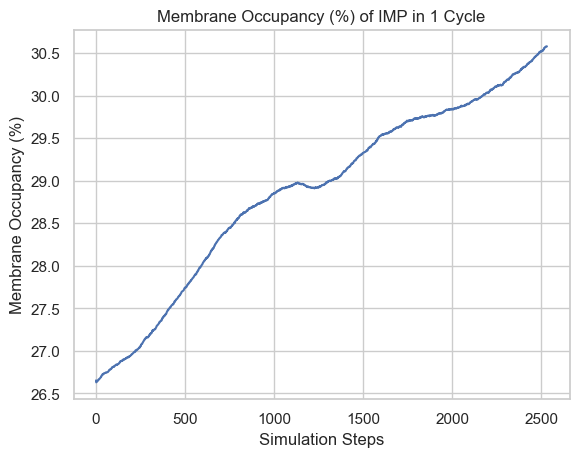

In [150]:
plt.plot(df_area_trans.sum(axis=1).values / (10**6) / St * 100)
plt.xlabel("Simulation Steps")
plt.ylabel("Membrane Occupancy (%)")
plt.title("Membrane Occupancy (%) of IMP in 1 Cycle")
